# Предсказание жанра по обложке музыкального альбома

**Цель работы:**

Цель данного проекта - разработать и обучить компьютерную модель, которая сможет автоматически определять музыкальный жанр альбома на основе визуального анализа его обложки.

**Данные:**

В нашем распоряжении 7800 обложек альбомов, принадлежащих 10 различным музыкальным жанрам. Изначально данные лежат в zip-архивах, название архива = название жанра. 

Для начала импортируем необходимые библиотеки. 

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

import faiss

RANDOM_STATE = 160224

pd.set_option('display.max_colwidth', None)

In [2]:
import torch
torch.cuda.get_arch_list()

['sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']

In [3]:
torch.cuda.is_available()

True

## Загрузка данных

Напишем функцию для извлечения изображений из архивов.

In [4]:
def extract_archives(archive_dir, extract_folder):
    for file in os.listdir(archive_dir):
        if file.endswith('.zip'):
            zip_path = os.path.join(archive_dir, file)
            
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_folder)

            print(f'Extracted {file} to {extract_folder}')

Напишем функцию, которая будет формировать список, содержащий полный путь к файлу и имя его родительской папки (то есть жанра). 

In [5]:
def list_files(directory):
    data = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            target = os.path.basename(root)
            data.append([file_path, target])
    return data

Проверим наличие файла album_images_paths.csv. В случае успеха будем просто использовать загруженный файл. 

Если же файл не найден:
- Определим текущую директорию как место хранения архивов (archive_dir).
- Зададим название и путь к папке extract_root для извлеченных данных.
- Проверим существование папки extract_root. Если она не существует, создадим эту папку с помощью os.mkdir.

Извлечем архивы, используя функцию extract_archives, передав текущую директорию и целевую папку для извлечения.
Сформируем данные о путях к файлам и их родительским каталогам, используя функцию list_files, которая пройдет по всем файлам в директории albums.
Сохраним полученные данные в DataFrame и запишем их в файл album_images_paths.csv для последующего использования.

In [6]:
try: 
    data = pd.read_csv('album_images_paths.csv')
    print('Found file with image paths')
except: 
    print('File with image paths was not found, creating it')
    
    # Папка, где хранятся архивы (текущая директория)
    archive_dir = os.getcwd()
    
    # Папка для извлечения архивов
    extract_root = 'albums'
    
    # Создаем корневую папку для извлечения, если она не существует
    # Извлекаем архивы
    if not os.path.exists(extract_root):
        os.mkdir(extract_root)
        extract_archives(os.getcwd(), extract_root)
        
    data = pd.DataFrame(list_files('albums'), columns=['file_path', 'target'])
    data.to_csv('album_images_paths.csv', index=False)

Found file with image paths


In [7]:
data.sample(5)

Unnamed: 0                                                  file_path  \
2159        2159  albums\classical\8ce78860-1182-3996-b1cb-cb97a914f8db.png   
5627        5627       albums\jazz\5d4babce-9bd0-447e-9741-4b68374c995d.png   
6054        6054       albums\jazz\ec3bd4b6-5af8-4a29-b8cd-a9745dd2c6ac.png   
2715        2715    albums\country\1756ddec-f9b4-36c4-9fc2-f24d113190aa.png   
4551        4551        albums\edm\011ace69-8a47-4b6a-acf7-759a75bc1453.png   

         target  \
2159  classical   
5627       jazz   
6054       jazz   
2715    country   
4551        edm   

                                                              embedding  
2159                                            [0. 0. 0. ... 0. 0. 0.]  
5627  [0.        0.        0.        ... 0.        0.        6.3277807]  
6054                                            [0. 0. 0. ... 0. 0. 0.]  
2715  [ 0.        0.        0.       ...  0.       15.355315  0.      ]  
4551                                            [0. 0. 0. ... 0. 0. 0.]

Посмотрим на случайно выбранные изображения.

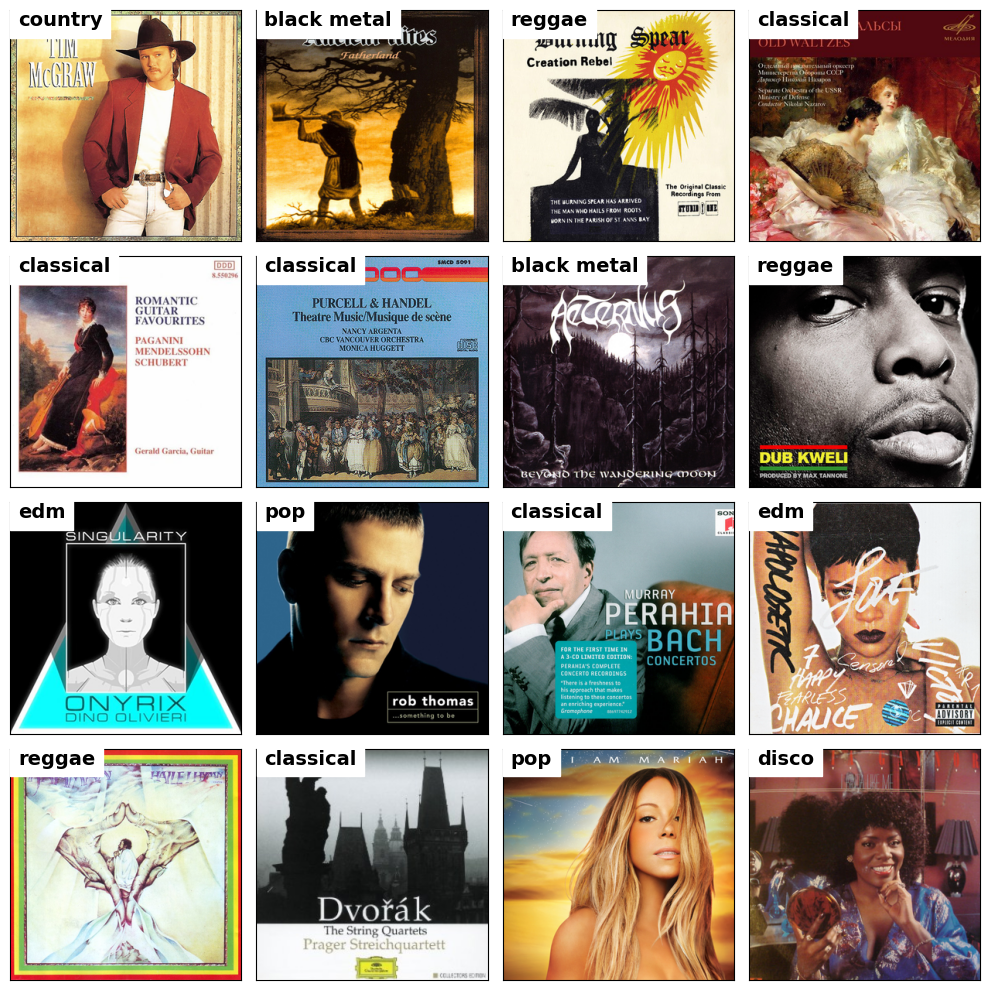

In [8]:
fig = plt.figure(figsize=(10,10))
show_data = data.sample(16) 

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    img_path = show_data['file_path'].iloc[i]
    img = Image.open(img_path)
    plt.imshow(img)
    plt.text(10, 20, str(show_data['target'].iloc[i]), color='black', backgroundcolor='white', fontsize=14, weight='semibold') 
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

plt.show() 

Напишем функцию для получения эмбеддингов из предобученной модели ResNet50. Для этого : 
1. Инициализируем базовую модель ResNet50 с весами, обученными на датасете ImageNet. Параметр include_top=False указывает на то, что мы не используем верхние слои сети (используемые для классификации), а pooling='avg' применяет усредняющий пулинг к выходным данным последнего сверточного слоя, что приводит к формированию одномерного вектора признаков.
2. Загрузим изображение и предобработаем его исходя из ожиданий предобученной модели
3. Получаем эмбеддинг с помощью метода predict
4. Вернем результат в виде одномерного массива

In [9]:
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg') 

def get_image_embedding_resnet50(img_path):
    img = image.load_img(img_path, target_size=(224, 224)) 
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data) 

    # Получаем эмбеддинг
    resnet_feature = base_model.predict(img_data)
    return resnet_feature.flatten() 

Из-за особенностей сохранения больших numpy массивов, сохранять их будем в виде строки. Напишем функцию, которая преобразует строку обратно в numpy массив. 

In [10]:
def string_to_array(s):
    s = s.strip('[]')
    return np.fromstring(s, sep=' ')

Проверим наличие файла embeddings.csv. Если файл найден, используем функцию string_to_array для преобразования строковых представлений эмбеддингов обратно в массивы.  
Если файл embeddings.csv не найден:
- Применим функцию get_image_embedding_resnet50 к каждому изображению, чтобы получить эмбеддинги. Результат сохраняем в столбец embedding.
- Преобразуем полученные эмбеддинги из массивов чисел в строковое представление, сохраним в столбце embedding_str.

Сохраняем полученные данные в embeddings.csv, чтобы каждый раз не обучать модель и не извлекать эмбеддинги по новой.

In [11]:
try:
    data = pd.read_csv('embeddings.csv')
    print('Found file with embeddings')
    data['embedding'] = data['embedding_str'].apply(string_to_array)
except:
    print('File with embeddings was not found, creating it')
    data['embedding'] = data['file_path'].apply(get_image_embedding_resnet50)
    data['embedding_str'] = data['embedding'].apply(lambda x: ' '.join(map(str, x)))
    data.to_csv('embeddings.csv', index=False)

Found file with embeddings


Обучим модель KNN (k-Nearest Neighbours)

In [13]:
X = np.stack(data['embedding'].values)
y = data['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [14]:
d = X_train.shape[1]  # размерность эмбеддингов
d

2048

Используем индекс IndexFlatL2 из библиотеки FAISS, который позволяет выполнять поиск L2-расстояния между векторами. 

In [15]:
index = faiss.IndexFlatL2(d)
index.add(X_train)

Выполним поиск в индексе для тестовых данных X_test. 

In [16]:
k = 7 

D, I = index.search(X_test, k)

Сформируем предсказания для тестового набора. Для каждого тестового образца определим наиболее часто встречающийся класс среди его k ближайших соседей. Принцип заключается в выборе класса с наибольшим количеством голосов среди соседей.

Затем создадим и выведем отчет о классификации. 

In [17]:
predictions = np.array([np.argmax(np.bincount(y_train_encoded[neighbors])) for neighbors in I])

accuracy = accuracy_score(y_test_encoded, predictions)

report = classification_report(y_test_encoded, predictions, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

       anime       0.63      0.77      0.69       254
 black metal       0.68      0.67      0.67        97
   classical       0.48      0.72      0.58       191
     country       0.45      0.65      0.53       296
       disco       0.21      0.15      0.18        85
         edm       0.63      0.34      0.44       144
        jazz       0.31      0.27      0.29       158
         pop       0.43      0.18      0.26       159
         rap       0.32      0.21      0.26        56
      reggae       0.57      0.28      0.38       120

    accuracy                           0.49      1560
   macro avg       0.47      0.42      0.43      1560
weighted avg       0.49      0.49      0.47      1560



Для алгоритма KNN, обученного на эмбеддингах изображений, получили accuracy равный 0.49.  

Лучшее значение F1 (0.69) показывает жанр anime, худшее (1.18) - disco.
Также неплохой показатель F1 у жанра black metal, достаточно плохие - у pop и rap.   

Возможно, такие результаты связаны с тем, что жанр anime имеет более уникальные и различимые визуальные характеристики на обложках, такие как яркие цвета, азиатские девушки на обложке. Это упрощает задачу классификации для модели.  
То же можно сказать о жанре black metal, который часто использует определенные цветовые схемы и стилистические элементы (например, готический шрифт, темные изображения).  
Жанры disco, pop и rap могут страдать от неоднородности в визуальном представлении их обложек. Обложки альбомов в этих жанрах могут быть более разнообразными в плане стиля, цвета и изображенных элементов. 

## Обучение нейросети

На данном этапе будем обучать нейросеть с использованием библиотеки fast.ai. 

In [18]:
torch.cuda.empty_cache()

Импортируем необходимые библиотеки. 

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from fastai.vision.all import *
from fastai.test_utils import *
from fastai.callback.core import Callback
from fastai.callback.tracker import EarlyStoppingCallback

RANDOM_STATE = 160224

Создадим загрузчик данных для обучения модели на изображениях, используя библиотеку PyTorch и её high-level API FastAI.  
Этот загрузчик данных будет использоваться для загрузки изображений альбомов, разделённых на обучающую и валидационную выборки.  
Установим процент валидационной выборки 25%, размер батча - 64 (максимальный для машины, на которой будет происходить обучение модели), зададим seed и явно укажем использование GPU для обучения модели.   

In [20]:
dataloader = ImageDataLoaders.from_folder('albums', 
                                          valid_pct=0.25,
                                          seed=RANDOM_STATE, 
                                          bs=64,
                                          device=torch.device('cuda'))

In [21]:
len(dataloader.train_ds.items)

5850

In [22]:
len(dataloader.valid_ds.items)

1950

### Подготовка к обучению 

In [23]:
class SavePlotsCallback(TrackerCallback):
    order = TrackerCallback.order+4
    def __init__(self, prefix = 'model'):
        self.prefix = prefix + '_'

    def after_fit(self):
        plt.ioff()

        plt.figure(figsize=(10, 6))
        self.learn.recorder.plot_loss() 
        loss_path = self.prefix + 'training_validation_loss.png'
        plt.savefig(loss_path)
        plt.close()

        plt.figure(figsize=(20, 12))
        self.learn.recorder.plot_sched()
        lr_path = self.prefix + 'learning_rate_schedule.png'
        plt.savefig(lr_path)
        plt.close()

        plt.ion()

        print(f'Training plots {loss_path} and {lr_path} saved')

Создадим метод для сохранения визуализаций обучения нейронной сети.  
Аргументы loss и sched представляют собой функции, которые при вызове генерируют графики потерь и график изменения скорости обучения соответственно.

In [24]:
def save_plots(model_name, loss, sched):

    loss() 
    loss_path = model_name + '_' + 'training_validation_loss.png'
    plt.savefig(loss_path)
    plt.close()
    
    sched()
    lr_path = model_name + '_' + 'learning_rate_schedule.png'
    plt.savefig(lr_path)
    plt.close()

    print(f'Training plots {loss_path} and {lr_path} saved')

Создадим функцию для отображения ранее сохранённых графиков потерь во время обучения и изменения скорости обучения модели. 

In [25]:
def show_saved_plots(model_name):
    img = mpimg.imread(model_name + '_training_validation_loss.png')
    plt.imshow(img)
    plt.axis('off') 
    plt.title("Training and Validation Loss")
    plt.show()
        
    img = mpimg.imread(model_name + '_learning_rate_schedule.png')
    plt.imshow(img)
    plt.axis('off')
    plt.title("Learning Rate Schedule")
    plt.show()

In [26]:
defaults.device = torch.device('cuda')

### Использование `fit_one_cycle()`

Создадим экземпляр vision_learner с использованием архитектуры ResNet34.  

Установим метрики для оценки модели - accuracy, Presicion, Recall, F1 (с учетом весов классов). Эти метрики помогут оценить модель, учитывая не только её точность, но и способность корректно классифицировать каждый класс, что важно в нашем случае несбалансированных данных.  

Сначала попытаемся загрузить предобученные веса с помощью метода load(). Если веса найдены, выполняется валидация модели, что позволит убедиться в корректности загруженных весов и готовности модели к дальнейшему использованию. После этого выводятся сохранённые ранее графики потерь и скорости обучения, что даст наглядное представление о процессе обучения модели.  

Если веса не найдены, начинается процесс обучения. Используется lr_find() для определения оптимальной скорости обучения. Подобранная таким образом скорость обучения используется затем в методе fit_one_cycle(). Комбинация EarlyStoppingCallback и ShowGraphCallback помогает предотвратить переобучение и дает возможность визуально оценить динамику обучения.  

После первоначального этапа обучения, модель "размораживается", что позволяет дообучить все слои сети, а не только последние. Это может помочь улучшить точность модели, так как дополнительно настраиваются признаки, извлекаемые на более ранних слоях. Повторно используется lr_find() для подбора новой скорости обучения. Так как мы уже знаем, что более ранние слои не требуют длительного обучения, используем низкие скорости обучения для более ранних слоев и более высокие для более поздних слоев. Настроим это, передав slice(suggested_lr/100, suggested_lr) в метод обучения модели. 

После завершения всех этапов обучения, графики потерь и изменения скорости обучения сохраняются вызовом save_plots().  цесса.

Model weights were not found, fitting


Suggested learning rate for the first training cycle: 0.0008317637839354575


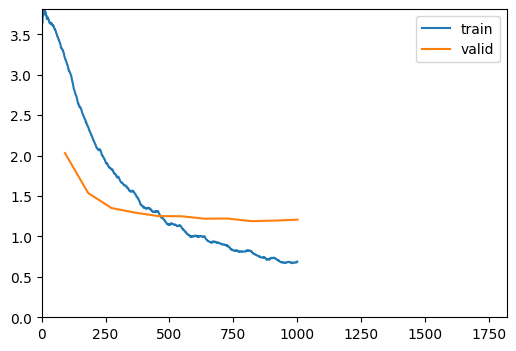

No improvement since epoch 8: early stopping


Suggested learning rate after unfreeze: 3.630780702224001e-05


Better model found at epoch 0 with valid_loss value: 1.2125427722930908.


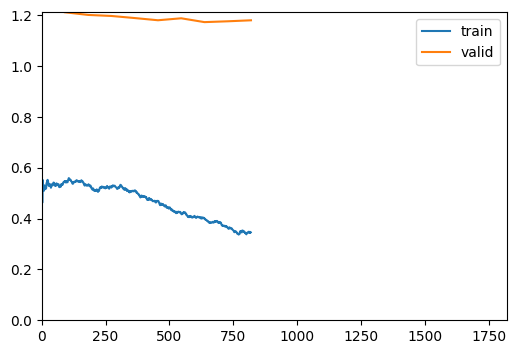

Better model found at epoch 1 with valid_loss value: 1.202078938484192.
Better model found at epoch 2 with valid_loss value: 1.1980060338974.
Better model found at epoch 3 with valid_loss value: 1.1898099184036255.
Better model found at epoch 4 with valid_loss value: 1.1811325550079346.
Better model found at epoch 6 with valid_loss value: 1.173762559890747.
No improvement since epoch 6: early stopping
Training plots resnet34_model_foc_training_validation_loss.png and resnet34_model_foc_learning_rate_schedule.png saved


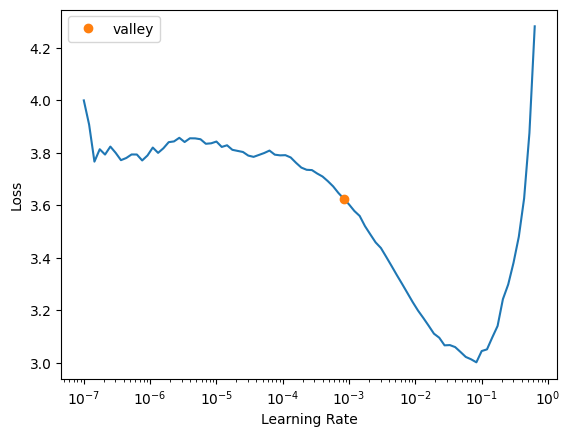

In [27]:
model_name = 'resnet34_model_foc'

learn_foc = vision_learner(dataloader, resnet34, metrics=[accuracy, 
                                                          Precision(average='weighted'), 
                                                          Recall(average='weighted'), 
                                                          F1Score(average='weighted')])

try: 
    learn_foc.load(model_name)
    learn_foc.validate()
    print('Model weights found and validated, showing `plot_loss()` and `plot_shed()` for trained model')
    show_saved_plots(model_name)

except FileNotFoundError:
    print('Model weights were not found, fitting')
    suggested_lr = learn_foc.recorder.lr_find().valley
    print(f'Suggested learning rate for the first training cycle: {suggested_lr}')
    
    learn_foc.fit_one_cycle(20, slice(suggested_lr), cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3), 
                                                          ShowGraphCallback()])
    
    learn_foc.unfreeze()
    suggested_lr = learn_foc.recorder.lr_find().valley
    print(f'Suggested learning rate after unfreeze: {suggested_lr}')
    learn_foc.fit_one_cycle(20, slice(suggested_lr/100, suggested_lr), cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3), 
                                                                 SaveModelCallback(monitor='valid_loss', fname=model_name, with_opt=True),
                                                                 ShowGraphCallback(),
                                                                 #SavePlotsCallback(model_name)
                                                                           ])

    save_plots(model_name, learn_foc.recorder.plot_loss, learn_foc.recorder.plot_sched)

Мы использовали early stopping, поэтому на шестой эпохи после разморозки обучение модели прекрастилось.  
Лучшая метрика accuracy, которую удалось достичь - 0.64. 
Были сохранены веса модели и графики. 

### Анализ результатов

Посмотрим на тестовой выборке, насколько хорошо модель справляется с предсказаниями.

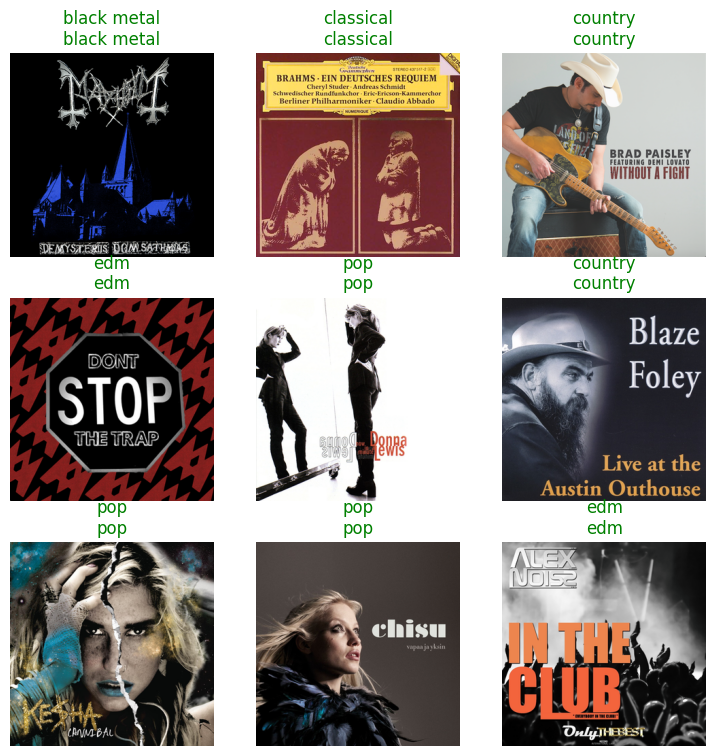

In [28]:
learn_foc.show_results()

В данной выборке модель правильно определила все жанры.

Изучим матрицу ошибок.

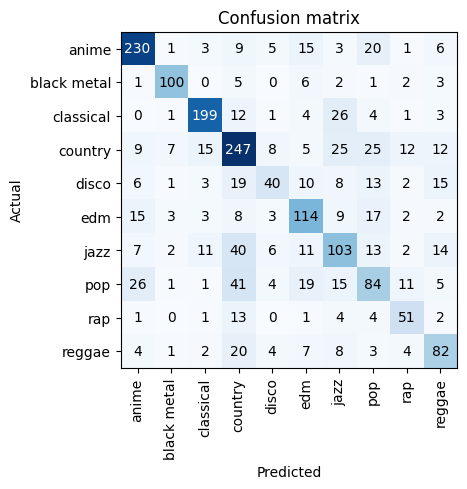

In [29]:
interp = ClassificationInterpretation.from_learner(learn_foc)
interp.plot_confusion_matrix()

Модель хорошо работает с жанрами, имеющими уникальные музыкальные характеристики (например, classical и black metal), но испытывает трудности с жанрами, которые могут иметь одинаковые стилистические черты (например, pop, disco, edm). У жанра аnime, например, основные ошибки происходят с жанрами pop (20 случаев) и jazz (15 случаев). Counrty часто путается с jazz и pop. 

Изучим, какие жанры путаются между собой чаще всего.

In [30]:
# Наиболее путаемые категории
interp.most_confused(min_val=2)[:5]

[('pop', 'country', 41),
 ('jazz', 'country', 40),
 ('classical', 'jazz', 26),
 ('pop', 'anime', 26),
 ('country', 'jazz', 25)]

Как мы видели на матрице ошибок, pop и coutry, country и jazz. 
Вероятно, для данных жанров пересекается визуал на обложках. 

Изучим, на каких пример модель совершила наибольшие ошибки. 

C:\Users\baby_\anaconda3\envs\newenv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


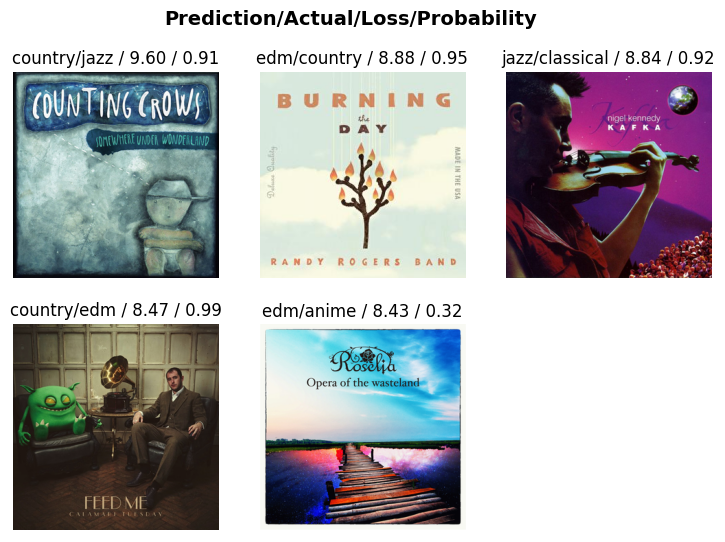

In [31]:
interp.plot_top_losses(5)

Country, edm, jazz - как мы уже видели, эти категории модель часто путает и не может определить корректно.

Напишем функцию для получения топ-5 предсказаний для обложек. 

In [36]:
def show_image_predictions(image_path, actual_class, model):
    img = PILImage.create(image_path)
    
    pred_class, pred_idx, probs = model.predict(img)
    
    top_probs, top_idxs = probs.topk(5)
    top_classes = [model.dls.vocab[i] for i in top_idxs]
    
    display(img)  
    print(f"Actual Class: {actual_class}")
    print("Top 5 Predictions:")
    for i, (p, cls) in enumerate(zip(top_probs, top_classes)):
        print(f"{i + 1}: {cls} with probability {p:.4f}")
    print()

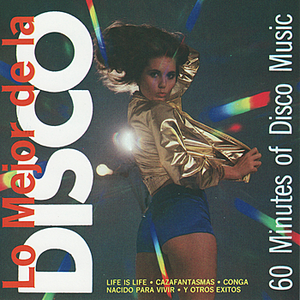

Actual Class: disco
Top 5 Predictions:
1: disco with probability 0.7661
2: anime with probability 0.1322
3: edm with probability 0.0389
4: reggae with probability 0.0322
5: pop with probability 0.0183



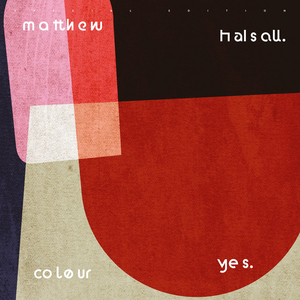

Actual Class: jazz
Top 5 Predictions:
1: jazz with probability 0.8471
2: disco with probability 0.0784
3: classical with probability 0.0386
4: edm with probability 0.0177
5: pop with probability 0.0082



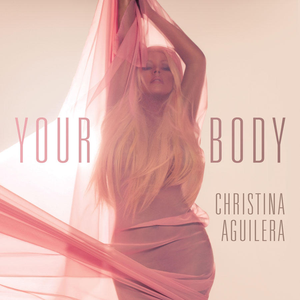

Actual Class: pop
Top 5 Predictions:
1: pop with probability 0.7663
2: anime with probability 0.1016
3: edm with probability 0.0730
4: jazz with probability 0.0358
5: country with probability 0.0162



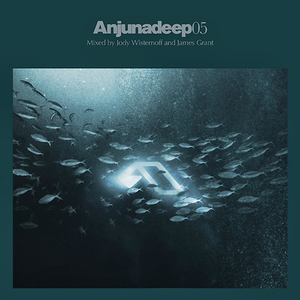

Actual Class: edm
Top 5 Predictions:
1: edm with probability 0.7612
2: pop with probability 0.1386
3: jazz with probability 0.0583
4: disco with probability 0.0226
5: black metal with probability 0.0172



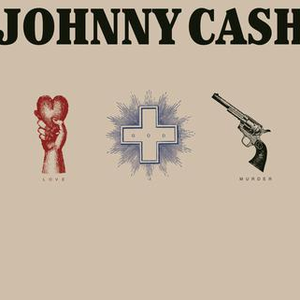

Actual Class: country
Top 5 Predictions:
1: country with probability 0.9398
2: edm with probability 0.0157
3: classical with probability 0.0142
4: jazz with probability 0.0117
5: disco with probability 0.0073



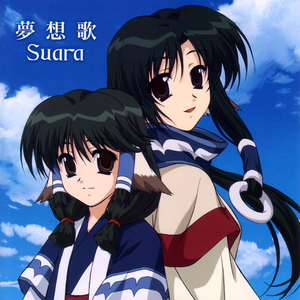

Actual Class: anime
Top 5 Predictions:
1: anime with probability 0.9989
2: pop with probability 0.0010
3: edm with probability 0.0001
4: country with probability 0.0000
5: rap with probability 0.0000



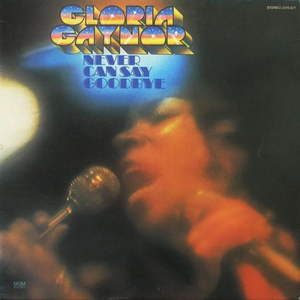

Actual Class: disco
Top 5 Predictions:
1: disco with probability 0.4178
2: black metal with probability 0.3089
3: reggae with probability 0.2421
4: edm with probability 0.0091
5: anime with probability 0.0091



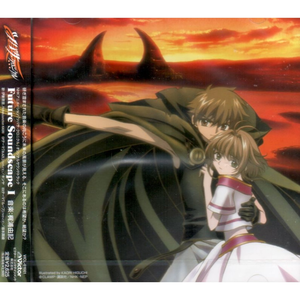

Actual Class: anime
Top 5 Predictions:
1: anime with probability 0.9995
2: pop with probability 0.0003
3: classical with probability 0.0001
4: country with probability 0.0000
5: jazz with probability 0.0000



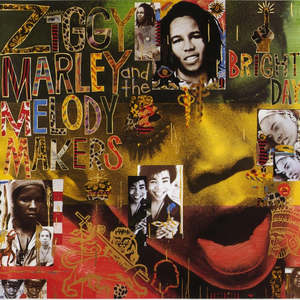

Actual Class: reggae
Top 5 Predictions:
1: reggae with probability 0.8721
2: jazz with probability 0.0542
3: anime with probability 0.0317
4: disco with probability 0.0246
5: classical with probability 0.0087



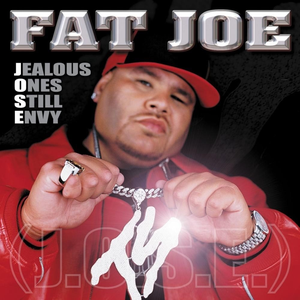

Actual Class: rap
Top 5 Predictions:
1: rap with probability 0.9721
2: edm with probability 0.0120
3: country with probability 0.0068
4: anime with probability 0.0032
5: pop with probability 0.0027



In [37]:
for index, row in data.sample(10).iterrows():
    show_image_predictions(row['file_path'], row['target'], learn_foc)

В данном примере видно, что чаще всего модель правильно угадывает жанр.  
Однако интересно посмотреть, как происходит определение жарна для "неоднозначных" жанров - тех, где модель часто путается.

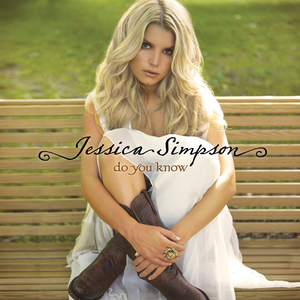

Actual Class: country
Top 5 Predictions:
1: country with probability 0.9709
2: pop with probability 0.0281
3: edm with probability 0.0002
4: jazz with probability 0.0002
5: disco with probability 0.0002



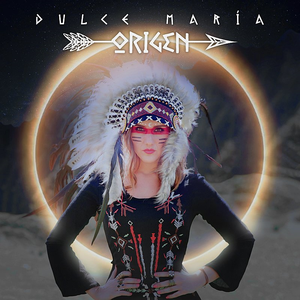

Actual Class: country
Top 5 Predictions:
1: country with probability 0.7446
2: anime with probability 0.1067
3: disco with probability 0.0687
4: edm with probability 0.0434
5: pop with probability 0.0318



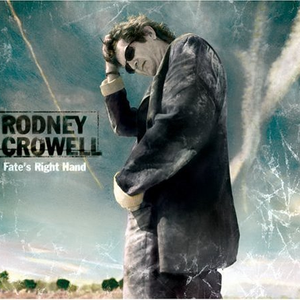

Actual Class: country
Top 5 Predictions:
1: country with probability 0.9681
2: reggae with probability 0.0195
3: rap with probability 0.0027
4: anime with probability 0.0022
5: edm with probability 0.0022



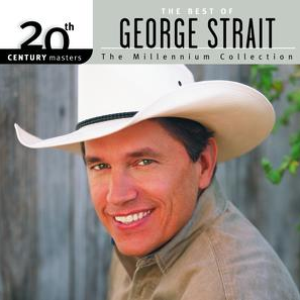

Actual Class: country
Top 5 Predictions:
1: country with probability 1.0000
2: pop with probability 0.0000
3: reggae with probability 0.0000
4: classical with probability 0.0000
5: black metal with probability 0.0000



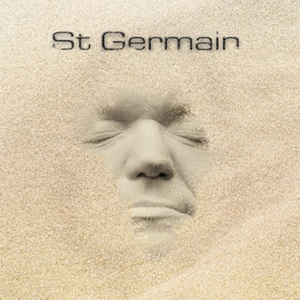

Actual Class: country
Top 5 Predictions:
1: jazz with probability 0.4325
2: country with probability 0.4178
3: disco with probability 0.0852
4: pop with probability 0.0541
5: edm with probability 0.0038



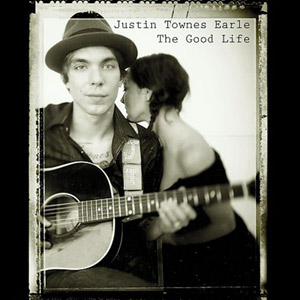

Actual Class: country
Top 5 Predictions:
1: country with probability 0.9996
2: jazz with probability 0.0001
3: rap with probability 0.0001
4: classical with probability 0.0001
5: reggae with probability 0.0000



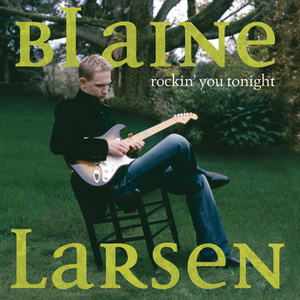

Actual Class: country
Top 5 Predictions:
1: country with probability 0.9911
2: pop with probability 0.0040
3: classical with probability 0.0036
4: jazz with probability 0.0009
5: reggae with probability 0.0002



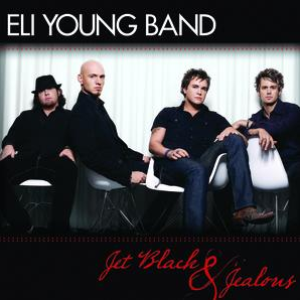

Actual Class: country
Top 5 Predictions:
1: country with probability 0.9669
2: jazz with probability 0.0117
3: rap with probability 0.0066
4: black metal with probability 0.0040
5: classical with probability 0.0036



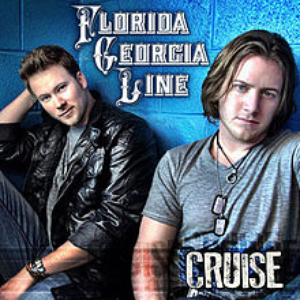

Actual Class: country
Top 5 Predictions:
1: country with probability 0.8603
2: disco with probability 0.0824
3: rap with probability 0.0241
4: jazz with probability 0.0136
5: pop with probability 0.0116



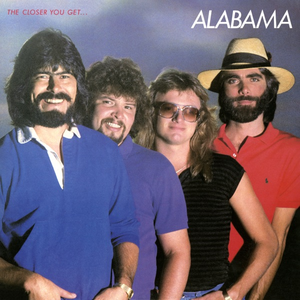

Actual Class: country
Top 5 Predictions:
1: country with probability 0.9096
2: rap with probability 0.0501
3: reggae with probability 0.0166
4: edm with probability 0.0103
5: pop with probability 0.0073



In [40]:
for index, row in data[data['target'] == 'country'].sample(10).iterrows():
    show_image_predictions(row['file_path'], row['target'], learn_foc)

Для одной обложки модель выдала вероятность жанра jazz выше реального country. 

## Вывод

Целью проекта было создание модели машинного обучения, способной автоматически определять жанр музыкального альбома по его обложке. Использовались данные, содержащие 7800 обложек музыкальных альбомов 10 различных жанров. Проект включал в себя несколько этапов: подготовку данных, извлечение признаков, обучение модели и оценку её эффективности.

**Подготовка данных**   
На начальном этапе были извлечены изображения из архивов и создан набор данных с путями к файлам и метками классов. 
На первом этапе для работы с изображениями использовалась модель ResNet50, которая позволила получить эмбеддинги изображений — векторы признаков, необходимые для дальнейшей классификации.

**Обучение бейзлайн-модели**  
Используя метод k-ближайших соседей (KNN) из библиотеки FAISS, была построена и обучена модель для классификации жанров. Модель KNN показала точность классификации 0.49. 

**Обучение нейронной сети**   
После KNN была обучена нейронная сеть с помощью библиотеки FastAI, при обучении использовалась архитектура ResNet34 и подход fit_one_cycle + unfreeze + fit_one_cycle. Этапы обучения включали настройку скорости обучения, контроль переобучения с помощью ранней остановки и динамическую адаптацию параметров модели. Также была внедрена функциональность сохранения модели при достижении лучших результатов, что позволяет избежать повторного обучения с нуля и гарантирует сохранность оптимальных параметров для дальнейшего использования.

**Оценка модели**  
Обучение нейронной сети позволило улучшить точность до 0.64. Результаты подтвердили, что модель эффективно распознаёт жанры с уникальными визуальными характеристиками обложек, такие как классическая и метал-музыка, но испытывает трудности с жанрами с схожими стилистическими чертами, например, поп и диско.

**Анализ ошибок**   
Был проведен анализ ошибок, который показал, какие жанры чаще всего путаются между собой. Ими оказались pop и country, jazz и country, classical и jazz, pop и anime, country и jazz. Обложки этих жанров часто содержат схожие визуальные признаки, что усложняет задачу классификации для модели. Также было замечено, что жанры с ярко выраженными уникальными элементами, такие как аниме и блэк-метал, лучше классифицируются. Это связано с тем, что обложки в этих жанрах часто используют стилизацию, характерную только для их музыкального направления.